In [1]:
# import necessary packages
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt

In [2]:
# load trained model
model = load_model('model/Complex.h5')

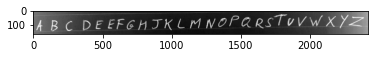

In [3]:
# load the image, convert to grayscale, and apply noise reduction
image = cv2.imread('data/test_images/6.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blurred, cmap='Greys')

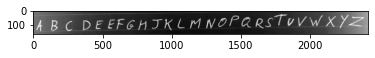

In [4]:
def brightness_correct(img, minimum_brightness):
    
    cols, rows = img.shape
    brightness = np.sum(img) / (255 * cols * rows)
    ratio = brightness / minimum_brightness
   
    if ratio >= 1:
        print("Image already bright enough")
        return img

    # Otherwise, adjust brightness to get the target brightness
    return cv2.convertScaleAbs(img, alpha = 1 / ratio, beta = 0)

correct = brightness_correct(blurred, 0.75) 

plt.imshow(correct, cmap='Greys')

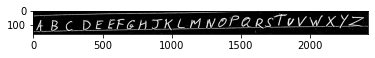

In [11]:
# Canny edge detection - use instead of otsu's thresholding for more exact but more segmented contours
# high_thresh, thresh_im = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# lowThresh = 0.5*high_thresh
# thresh = cv2.Canny(blurred, lowThresh, high_thresh)

# apply otsu's thresholding - can be used instead of canny
# ret, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# adaptive gaussian thresholding - something to try
thresh = cv2.adaptiveThreshold(blurred, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

# visualize the binary image
plt.imshow(thresh, cmap='Greys')

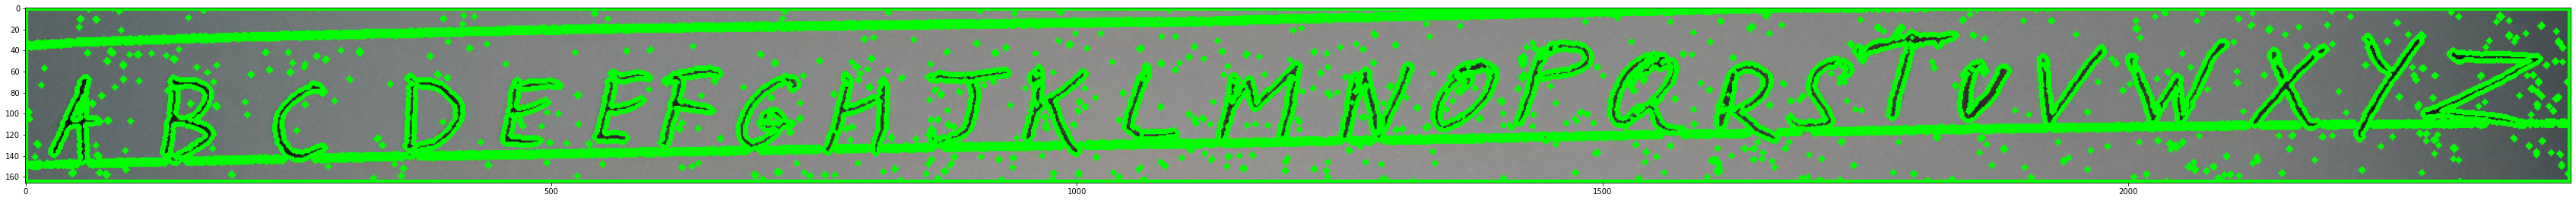

In [13]:
# extract contours from the binary image
cnts, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# display contours over temporary image
temp = image.copy()
cv2.drawContours(temp, cnts, -1, (0, 255, 0), 3)
fig, ax = plt.subplots(figsize=(60, 14))
plt.imshow(temp)

In [14]:
# sort left to right
cnts = sort_contours(cnts, method="left-to-right")[0]
# initialize the list of boxes and associated characters
chars = []

In [15]:
# establish min and max relative sizes for boxes
max_w = image.shape[1] * 0.7
min_w = image.shape[1] * 0.01
max_h = image.shape[0] * 0.7
min_h = image.shape[0] * 0.03

In [16]:
# intialize plotter
# fig, axs = plt.subplots(1, len(cnts))

# loop over the contours
for i, c in enumerate(cnts):
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)
    
    # filter out very large and very small boxes
    if (w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
    
        # extract the character and threshold as white on black and retrieve dimensions
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        (tH, tW) = thresh.shape
        # if the width is greater than the height, resize along the width dimension
        if tW > tH:
            thresh = imutils.resize(thresh, width=28)
        else:
            thresh = imutils.resize(thresh, height=28)
        # retrieve resized dims and pad determine if padding is necessary
        (tH, tW) = thresh.shape
        dX = int(max(0, 36 - tW) / 2.0)
        dY = int(max(0, 36 - tH) / 2.0)
        # pad the image and force 28x28 dimensions
        padded = cv2.copyMakeBorder(thresh,
                                    top=dY,
                                    bottom=dY,
                                    left=dX,
                                    right=dX,
                                    borderType=cv2.BORDER_CONSTANT,
                                    value=(0, 0, 0))
        padded = cv2.resize(padded, (28, 28))
        # perform final preprocessing for OCR
        padded = padded.astype("float32") / 255.0
        padded = np.expand_dims(padded, axis=-1)
        # plot padded image
        # axs[i].imshow(padded)
        # update our list of characters that will be OCR'd
        chars.append((padded, (x, y, w, h)))

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4055: error: (-215:Assertion failed) inv_scale_x > 0 in function 'cv::resize'


In [17]:
# extract the bounding box locations and padded characters
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")

In [11]:
# OCR the characters using our handwriting recognition model
preds = model.predict(chars)
# define the list of label names
alpha = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in alpha]

In [12]:
# loop over the predictions and bounding box locations together
for (pred, (x, y, w, h)) in zip(preds, boxes):
    # extract most likely label, probability
    i = np.argmax(pred)
    prob = pred[i]
    label = labelNames[i]
    # draw the prediction on the image
    print("[INFO] {} - {:.2f}%".format(label, prob * 100))
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, label, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

[INFO] C - 100.00%
[INFO] D - 99.99%
[INFO] E - 99.99%
[INFO] E - 100.00%
[INFO] F - 99.97%
[INFO] G - 100.00%
[INFO] H - 94.17%
[INFO] J - 100.00%
[INFO] K - 100.00%
[INFO] L - 100.00%
[INFO] M - 99.99%
[INFO] N - 100.00%
[INFO] O - 100.00%
[INFO] P - 100.00%
[INFO] Q - 100.00%
[INFO] R - 100.00%
[INFO] S - 100.00%
[INFO] T - 99.99%
[INFO] U - 98.86%
[INFO] V - 100.00%
[INFO] W - 100.00%


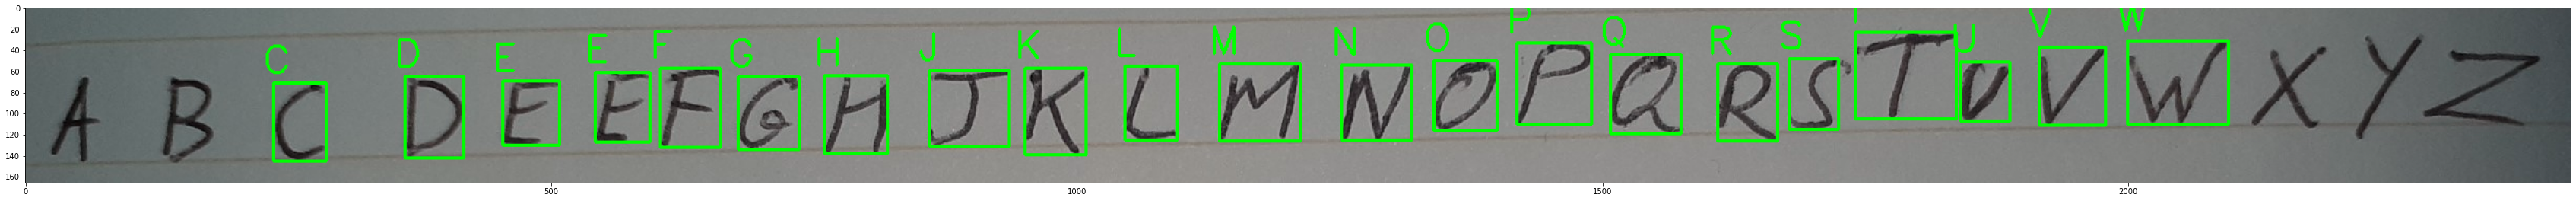

In [13]:
# show image with overlay
fig, ax = plt.subplots(figsize=(60, 14))
plt.imshow(image)